**Анализ аренд самокатов. В этом проекте с помощью собранных для нас баз данных мы проверим гипотезы которые смогут помочь бизнесу вырасти.
Основной вопрос действительно ли пользователи с подпиской приносят больше прибыли компании нежели без неё**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import stats as st
import math

#### Загрузка данных

In [2]:
data_user = pd.read_csv('/datasets/users_go.csv')
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_sub = pd.read_csv('/datasets/subscriptions_go.csv')
print(data_user.head(5))
print(data_rides.head(5))
print(data_sub.head(5))

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
   user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28
  subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199


In [3]:
print(data_user.info(0))
print(data_rides.info(0))
print(data_sub.info(0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns)

In [4]:
data_u_r = data_user.merge(data_rides, how = 'outer')
data = data_u_r.merge(data_sub, how = 'outer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18388 entries, 0 to 18387
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            18388 non-null  int64  
 1   name               18388 non-null  object 
 2   age                18388 non-null  int64  
 3   city               18388 non-null  object 
 4   subscription_type  18388 non-null  object 
 5   distance           18388 non-null  float64
 6   duration           18388 non-null  float64
 7   date               18388 non-null  object 
 8   minute_price       18388 non-null  int64  
 9   start_ride_price   18388 non-null  int64  
 10  subscription_fee   18388 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.7+ MB


**Мы объединили все датафреймы для удобства работы. Теперь вся необходимая информация находится в одном DF.
Данные в целом целые, но нужно будет разобраться с типом данных в некоторых столбцах. Пропущенных значений нет, нужно проверить на дубликаты**

#### Шаг 2. Предобработка данных

In [5]:
data_rides['date'] = pd.to_datetime(data_rides.date, dayfirst = True)
data_rides['month'] = data_rides['date'].dt.month

**Создали дополнительный столбец "месяц"**

In [6]:
data_rides['duration'].duplicated().sum()

94

In [7]:
data_rides[data_rides['duration'].duplicated()]

,user_id,distance,duration,date,month
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
6860,724,6225.520342,0.5,2021-12-16,12
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [8]:
data_rides = data_rides.drop_duplicates(subset = 'duration')

In [9]:
data_rides['duration'].duplicated().sum()

0

**В данном разделе мы избавились от дубликатов, предполагаю, что они появились из-за того, что пользователи брали в аренду самокат и сразу отменяли по тем или иным причинам, а минимальное время записывалось как пол минуты. А при том что время поездки записывается вплость до миллионной секунды, то что в данном DF будет два идентичных значения маловероятно. Пропущенных значений обнаружено не было. Среди остальных данных поиск дубликатов будет бессмысленен, т.к имена города и тд, так или иначе будут повторяться.**

#### Шаг 3. Исследовательский анализ данных

In [10]:
data_user['city'].value_counts()

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, 'Тюмень'),
  Text(0.0, 0, 'Екатеринбург'),
  Text(1.0, 0, 'Краснодар'),
  Text(2.0, 0, 'Москва'),
  Text(3.0, 0, 'Омск'),
  Text(4.0, 0, 'Пятигорск'),
  Text(5.0, 0, 'Ростов-на-Дону'),
  Text(6.0, 0, 'Сочи'),
  Text(7.0, 0, 'Тюмень'),
  Text(8.0, 0, '')])

<Figure size 7200x7200 with 0 Axes>

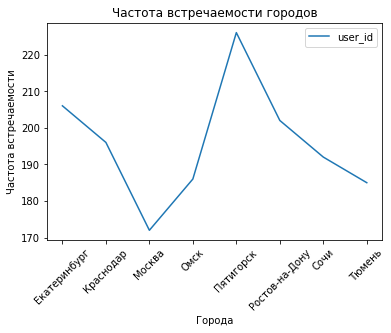

In [11]:
plt.figure(figsize=(100, 100))
(
    data_user.pivot_table(index = 'city', values = 'user_id', aggfunc = 'count')
    .plot(title='Частота встречаемости городов', xlabel='Города', ylabel='Частота встречаемости')
);
plt.xticks(rotation=45)

**Тут мы можем видеть, что нибольший спрос самокаты имеют в Пятигорске и наименьший в Москве. Такие данные могут быть из-за того что в столице большая конкуренция, либо из-за того что Москва большой город и добираться до куда-то порой проще на альтернативном, но более быстром транспорте, например метро**

In [12]:
data_user['subscription_type'].value_counts()

free     846
ultra    719
Name: subscription_type, dtype: int64

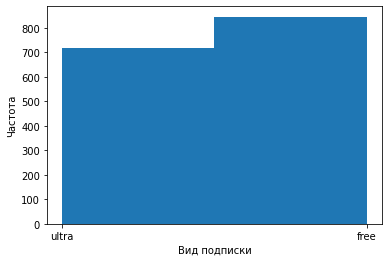

In [13]:
plt.hist(data_user['subscription_type'],bins = 2)
plt.xlabel('Вид подписки')
plt.ylabel('Частота')
plt.show()

**Кол-во людей без подписки незначительно, но меньше**

In [14]:
data_user['age'].value_counts()

25    149
26    133
23    133
24    132
27    124
22    120
28    116
21     94
20     72
29     72
30     70
19     49
31     48
18     46
32     41
33     40
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

Text(0, 0.5, 'Частота')

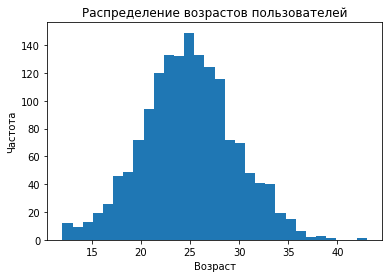

In [38]:
data_user['age'].plot(kind = 'hist', bins = 30, title='Распределение возрастов пользователей');
plt.xlabel('Возраст')
plt.ylabel('Частота')

In [16]:
data_user['age'].value_counts()

25    149
26    133
23    133
24    132
27    124
22    120
28    116
21     94
20     72
29     72
30     70
19     49
31     48
18     46
32     41
33     40
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

In [50]:
data_user['age'].describe()

count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

**Больше всего молодых людей около 25 лет, предполагаю это связано с тем, что они уже платёжеспособны, чтобы брать самокаты в аренду и при этом достаточно молоды, чтобы не считать это детским развлечением**

Text(0, 0.5, 'Частота')

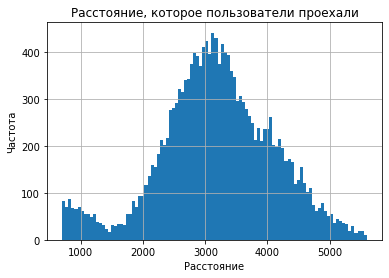

In [39]:
data_rides['distance'].plot(kind = 'hist', bins = 100, title='Расстояние, которое пользователи проехали', grid = True);
plt.xlabel('Расстояние')
plt.ylabel('Частота')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fda6eb77b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fda6eb07280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fda6eb77820>],
 'medians': [<matplotlib.lines.Line2D at 0x7fda6eb07970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fda6eb07cd0>],
 'means': []}

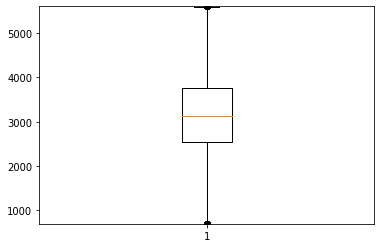

In [18]:
plt.ylim(700, 5600)
plt.boxplot(data_rides['distance'])

Text(0, 0.5, 'Частота')

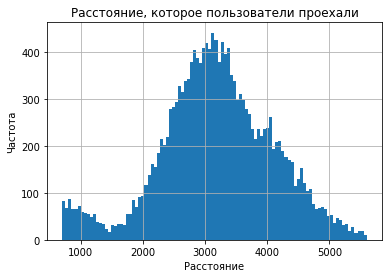

In [40]:
data_rides = data_rides.query('700 < distance < 5600')
data_rides['distance'].plot(kind = 'hist', bins = 100, range =(700, 5600), title='Расстояние, которое пользователи проехали', grid = True);
plt.xlabel('Расстояние')
plt.ylabel('Частота')

In [49]:
data_rides['distance'].describe()

count    16862.000000
mean      3179.935472
std        917.989000
min        701.138423
25%       2637.909553
50%       3166.079874
75%       3780.482351
max       5594.753114
Name: distance, dtype: float64

**Избавились от выбросов, слишком малые могли быть из-за изменений планов пользователя, либо из-за неисправности самокатов. Слишком большие могли быть из-за сбоев в работе GPS-трекеров, либо других неисправностей"**

Text(0, 0.5, 'Частота')

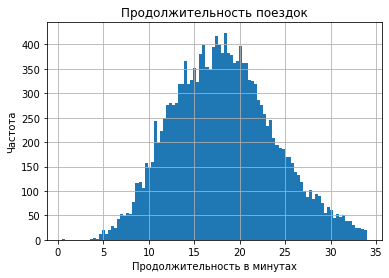

In [41]:
data_rides['duration'].plot(kind = 'hist', bins = 100, title='Продолжительность поездок', grid = True);
plt.xlabel('Продолжительность в минутах')
plt.ylabel('Частота')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fda6ec9b0a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fda6ec9bbb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fda6ec8ac40>],
 'medians': [<matplotlib.lines.Line2D at 0x7fda6ec6b970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fda6ec6b340>],
 'means': []}

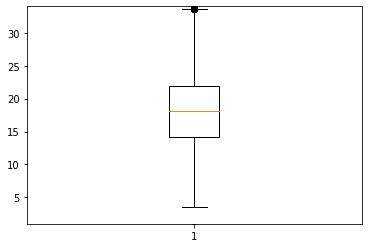

In [21]:
plt.ylim(1, 34)
plt.boxplot(data_rides['duration'])

Text(0, 0.5, 'Частота')

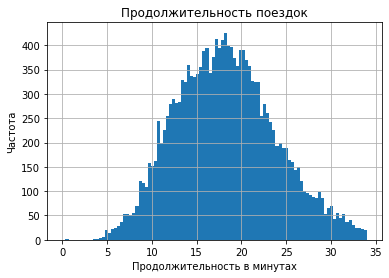

In [42]:
data_rides = data_rides.query('0 < duration < 34')
data_rides['duration'].plot(kind = 'hist', bins = 100, range =(0, 34), title='Продолжительность поездок', grid = True)
plt.xlabel('Продолжительность в минутах')
plt.ylabel('Частота')

In [48]:
data_rides['duration'].describe()

count    16862.000000
mean        18.258239
std          5.576320
min          0.500000
25%         14.176739
50%         18.031562
75%         21.887291
max         33.987812
Name: duration, dtype: float64

**Продолжительность поездок наблюдается в виде нормального распределения, было несколько выбросов сверху. Скорее всего из-за забытой закрытой аренды.**

#### Шаг 4. Объединение данных

In [23]:
data_u_r = data_user.merge(data_rides, how = 'outer')
data = data_u_r.merge(data_sub, how = 'outer')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17161 entries, 0 to 17160
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17161 non-null  int64         
 1   name               17161 non-null  object        
 2   age                17161 non-null  int64         
 3   city               17161 non-null  object        
 4   subscription_type  17161 non-null  object        
 5   distance           17161 non-null  float64       
 6   duration           17161 non-null  float64       
 7   date               17161 non-null  datetime64[ns]
 8   month              17161 non-null  int64         
 9   minute_price       17161 non-null  int64         
 10  start_ride_price   17161 non-null  int64         
 11  subscription_fee   17161 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.7+ MB


**Я сделал это ещё в начале проекта, но подумал, раз какие-то данныые удалялись (например выбросы), то повторю объединение. Но не совсем понимаю, почему не объединить их в самом начале**

In [47]:
data_free = data[data['subscription_type'] == 'free']
data_ultra = data[data['subscription_type'] == 'ultra']
print(data_free.head(5),data_ultra.head(5))

      user_id   name  age  city subscription_type     distance   duration  \
6533      700  Айдар   22  Омск              free  2515.690719  14.944286   
6534      700  Айдар   22  Омск              free   846.932642  16.234663   
6535      700  Айдар   22  Омск              free  4004.434142  20.016628   
6536      700  Айдар   22  Омск              free  1205.911290   9.782872   
6537      700  Айдар   22  Омск              free  3047.379435  17.427673   

           date  month  minute_price  start_ride_price  subscription_fee  
6533 2021-01-02      1             8                50                 0  
6534 2021-02-01      2             8                50                 0  
6535 2021-02-04      2             8                50                 0  
6536 2021-02-10      2             8                50                 0  
6537 2021-02-14      2             8                50                 0      user_id  name  age    city subscription_type     distance   duration  \
0        1  

**Мы разделили ДФ на две категории, те, где подписка есть и те, где подписки нет. Это нужно для того, чтобы можно было сравнить эти две категории пользователей**

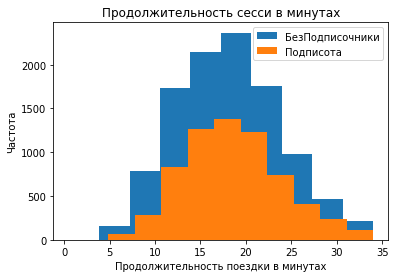

In [51]:
plt.hist(data_free['duration'], label = 'БезПодписочники')
plt.hist(data_ultra['duration'], label = 'Подписота')
plt.title('Продолжительность сесси в минутах')
plt.legend(loc='upper right')
plt.xlabel('Продолжительность поездки в минутах')
plt.ylabel('Частота')
plt.show()

**Судя по гистограмме, можно заметить, что люди НЕ пользующиеся подпиской ездят по времени в среднем больше, возможно это связано с тем, что без подписки старт платный и люди не хотят платить за то, чтобы прокатиться 3 минуты**

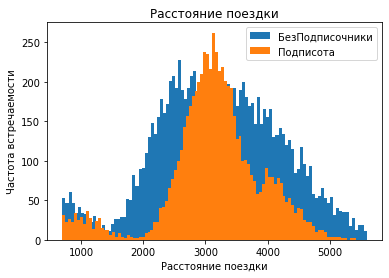

In [57]:
plt.hist(data_free['distance'],bins = 100, label = 'БезПодписочники')
plt.hist(data_ultra['distance'],bins = 100, label = 'Подписота')
plt.title('Расстояние поездки')
plt.legend(loc='upper right')
plt.xlabel('Расстояние поездки')
plt.ylabel('Частота встречаемости')
plt.show()

**В плане расстояния люди с подпиской чаще ездят на большие расстояния, нежели пользователи без подписки. Это может быть связано с тем, что подписчики часто ездят одним и тем же маршрутом, например на работу или на учёбу, а люди без подписок берут самокаты не так часто и больше для развлечения**

**Действительно, заметно, что те кто катается по подписке имеют пик в районе 3000м, в то время как у пользователей без подписки более плавное распределение расстояния. Но моё предположение, что подписчики чаще берут самокаты именно для нужды, а не для развлечения становится только твёрже**

#### Шаг 5. Подсчёт выручки

In [28]:
new_data = data.pivot_table(index = ['user_id','month', 'subscription_type'],
                            values = ['distance', 'duration'], 
                            aggfunc = [sum, len])
new_data = new_data.reset_index()
new_data.columns = ['user_id','month', 'subscription_type', 'sum_distance', 'sum_duration','count','gone']
new_data.head(5)

,user_id,month,subscription_type,sum_distance,sum_duration,count,gone
0,1,1,ultra,7027.511294,41.416640,2.0,2.0
1,1,4,ultra,754.159807,6.232113,1.0,1.0
2,1,8,ultra,6723.470560,44.776802,2.0,2.0
3,1,10,ultra,5809.911100,31.578017,2.0,2.0
4,1,11,ultra,7003.499363,53.397424,3.0,3.0


**Мы смогли собрать данные за каждый месяц, теперь можно приступить к сбору данных о выручке.
P.S. Если есть более лаконичное решение, буду признателен за подсказку.**

In [29]:
new_data = new_data.merge(data_sub)
new_data['sum_duration'] = np.ceil(new_data['sum_duration'])
new_data['cash'] = new_data['start_ride_price'] * new_data['count'] + new_data['minute_price'] * new_data['sum_duration'] + new_data['subscription_fee']
new_data.head(5)

,user_id,month,subscription_type,sum_distance,sum_duration,count,gone,minute_price,start_ride_price,subscription_fee,cash
0,1,1,ultra,7027.511294,42.0,2.0,2.0,6,0,199,451.0
1,1,4,ultra,754.159807,7.0,1.0,1.0,6,0,199,241.0
2,1,8,ultra,6723.470560,45.0,2.0,2.0,6,0,199,469.0
3,1,10,ultra,5809.911100,32.0,2.0,2.0,6,0,199,391.0
4,1,11,ultra,7003.499363,54.0,3.0,3.0,6,0,199,523.0


**Мы выяснили количество прибыли, которую приносит каждый пользователь в каждый месяц**

#### Шаг 6. Проверка гипотез

In [30]:
#нулевая гипотеза, что подписчики и безподписочники тратят одинаковое кол-во времени на поездки
#Альтернативная гипотеза - пользователи с подпиской тратя больше времени на поездки, чем пользователи без подписки
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative = 'greater')
alpha = 0.05
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 6.84311058271332e-08
Отвергаем нулевую гипотезу


**Мы выяснили, что пользователи с подпиской по времени ездят больше нежели те, кто без подписки. Нулевая гипотеза, что подписчики и безподписочники тратят одинаковое кол-во времени на поездки отвергается в пользу альтернативной -  пользователи с подпиской тратя больше времени на поездки, чем пользователи без подписки**

In [31]:
#нулевая гипотеза, что поездка пользователя с подпиской равна 3130 метров
#Альтернативная гипотеза - поездки пользователей с подпиской не превышают 3130  метров
results = st.ttest_1samp(data_ultra['duration'], 3130, alternative = 'less')
alpha = 0.05
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.0
Отвергаем нулевую гипотезу


**В самом деле оказывается, что поездка на самокате пользователями с подпиской не превышет 3130 метров. Нулевая гипотеза, что поездка пользователя с подпиской равна 3130 метров, отвергается в пользу альтернативной - поездки пользователей с подпиской не превышают 3130  метров**

In [32]:
new_data

,user_id,month,subscription_type,sum_distance,sum_duration,count,gone,minute_price,start_ride_price,subscription_fee,cash
0,1,1,ultra,7027.511294,42.0,2.0,2.0,6,0,199,451.0
1,1,4,ultra,754.159807,7.0,1.0,1.0,6,0,199,241.0
2,1,8,ultra,6723.470560,45.0,2.0,2.0,6,0,199,469.0
3,1,10,ultra,5809.911100,32.0,2.0,2.0,6,0,199,391.0
4,1,11,ultra,7003.499363,54.0,3.0,3.0,6,0,199,523.0
...,...,...,...,...,...,...,...,...,...,...,...
10902,1534,6,free,3214.021065,19.0,1.0,1.0,8,50,0,202.0
10903,1534,8,free,7622.453034,48.0,2.0,2.0,8,50,0,484.0
10904,1534,9,free,4928.173852,23.0,1.0,1.0,8,50,0,234.0
10905,1534,11,free,13350.015305,77.0,4.0,4.0,8,50,0,816.0


In [33]:
new_data_ultra = new_data[new_data['subscription_type'] == 'ultra']
new_data_free = new_data[new_data['subscription_type'] == 'free']

In [59]:
#нулевая гипотеза, что помесячная выручка пользователей с подпиской равна выручке пользователей без подписки
#Альтернативная гипотеза - пользователи с подпиской приносят больше денег компании нежели пользователи без подписки
results = st.ttest_ind(new_data_ultra['cash'], new_data_free['cash'], alternative = 'greater')
alpha = 0.05
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2684371173252376e-41
Отвергаем нулевую гипотезу


**Судя по всему помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки**

**Ответ на вопрос 6.4: в данной ситуации помог бы t-тест для проверки гипотез о равенстве средних для зависимых выборок. scipy.stats.ttest_rel(). В качестве параметра можно выбрать одностороннюю гипотезу (левостороннюю), чтобы выяснить, снизилось ли кол-во обращений**

**Проверив гипотезы мы можем предположить, что пользователи с подпиской приносят больше прибыли компании нежели пользователи без подписки. Поэтому имеет смысл найти способ простимулировать покупку подписок пользователями**

#### Шаг 7. Распределения

In [60]:
n = 100
p = 0.1
mu = n*p
sigma = math.sqrt(n*p*(1-p))
distr = st.norm(mu,sigma)
result = distr.cdf(5)
result

0.0477903522728147

**Проверив гипотезы мы можем предположить, что пользователи с подпиской приносят больше прибыли компании нежели пользователи без подписки. Поэтому имеет смысл найти способ простимулировать покупку подписок пользователями.
Даже учитывая что минута с подпиской стоит меньше, пользователи с подпиской чаще ездят и скорее всего на более длительные поездки и в отличии от пользователей без подписки. Так же те у кого есть подписко стабильно ездят на около 3000м расстояния, в то время как расстояние поездок пользователей без подписок более плавно распределено.**

**Я считаю, что для увеличения прибыли компании, стоит вложиться в продвижение подписок и увеличение их продаж**